## Nutriend Demand



In [1]:
#installing necessary requirements

!pip install CFEDemands --upgrade --pre
!pip install xarray --upgrade
!pip install h5netcdf

Requirement already up-to-date: CFEDemands in /srv/app/venv/lib/python3.6/site-packages
You are using pip version 9.0.3, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: xarray in /srv/app/venv/lib/python3.6/site-packages
Requirement already up-to-date: pandas>=0.25 in /srv/app/venv/lib/python3.6/site-packages (from xarray)
Requirement already up-to-date: setuptools>=41.2 in /srv/app/venv/lib/python3.6/site-packages (from xarray)
Requirement already up-to-date: numpy>=1.15 in /srv/app/venv/lib/python3.6/site-packages (from xarray)
Requirement already up-to-date: pytz>=2017.2 in /srv/app/venv/lib/python3.6/site-packages (from pandas>=0.25->xarray)
Requirement already up-to-date: python-dateutil>=2.6.1 in /srv/app/venv/lib/python3.6/site-packages (from pandas>=0.25->xarray)
Requirement already up-to-date: six>=1.5 in /srv/app/venv/lib/python3.6/site-packages (from python-dateutil>=2.6.1->pandas>=

In [2]:
#loading dataset provided by Ligon

import cfe

r = cfe.from_dataset('Ethiopia_small.ds')

r['alpha'] = r.alpha.loc[r.alpha>0]  # Insisting on alpha positive

/usr/lib/python3.6/abc.py:133: FutureWarning: xarray subclass Result should explicitly define __slots__
  cls = super().__new__(mcls, name, bases, namespace, **kwargs)
/srv/app/venv/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Choosing reference prices, budget, and units



In [3]:
r.prices.coords

Coordinates:
  * i        (i) object 'Banana' 'Barley' 'Beef' ... 'Tella' 'Tomato' 'Wheat'
  * t        (t) int64 2011 2013 2015
  * m        (m) int64 1
  * u        (u) object '40' 'Araba' ... 'Zorba/Akara \xa0  Small'

In [4]:
t = r.firstround  # First round
m = r.coords['m'][0]

# Get median budget
x = r.get_predicted_expenditures().sum('i')
medianx = x.where(x>0).sel(t=t,m=m).median('j').values

# Using only data from 2015 & with foods only measured in kilograms
p = r.prices.sel(t=2015,m=1,u='Kilogram',drop=True).to_dataframe().squeeze().dropna()
p

/srv/app/venv/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/srv/app/venv/lib/python3.6/site-packages/xarray/core/nputils.py:215: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


i
Banana                                       12.461725
Barley                                        9.199638
Beef                                         48.674426
Beer                                         15.000000
Butter/ghee                                 123.525912
Cassava                                      16.000000
Chat / Kat                                   14.316194
Cheese                                       35.888889
Chick Pea                                    17.040066
Coffee                                        0.238007
Eggs                                          2.898480
Field Pea                                    21.215840
Fish                                         11.460259
Goat & mutton meat                           39.933168
Godere                                        9.600000
Green chili pepper (kariya)                   1.456026
Greens (kale, cabbage, etc.)                  8.273038
Ground nuts                                  17.743590
Haricot 

And with $(x,p)$ defined we can calculate example demands:



In [5]:
# Expenditures divided by reference prices per Kilogram
c=(r.demands(medianx)/p).dropna()
c

i
Banana            0.386586
Barley            8.342361
Chat / Kat        0.970994
Chick Pea         1.626869
Coffee           25.505076
Eggs              0.940972
Haricot Beans    26.838256
Horsebeans        1.162374
Lentils           0.173938
Maize             6.101013
Milk              0.571989
Onion             0.395878
Potato            0.478743
Salt             67.053756
Sorghum          17.239479
Sugar             0.298363
Teff              0.635264
Wheat            10.835731
dtype: float64

## Mapping to Nutrients



In [6]:
# installing some more requirements if necessary 
# !pip install -r requirements.txt

In [9]:
import pandas as pd

In [10]:
#user info to use food data central
user = "mprakasam"
apikey = {'mprakasam':"x6M5kQkjnIRGplxtj6JtiZIvMaWHjQWwIpKye4kH"}

In [11]:
#reading in FDC codes for Ethiopian foods
df = pd.read_csv('Data/FDC.csv')

In [13]:
import fooddatacentral as fdc

#creating DataFrame that contains nutritional information for our foods
D = {}
count = 0
for food in  df.Food.tolist():
    try:
        FDC = df.loc[df.Food==food,:].FDC[count]
        count+=1
        D[food] = fdc.nutrients(apikey[user],FDC).Quantity
    except AttributeError: 
        warnings.warn("Couldn't find FDC Code %s for food %s." % (food,FDC))        

D = pd.DataFrame(D,dtype=float)

In [14]:
#transposing our DataFrame to get nutrients as our index
fct = D.T

In [15]:
import pandas as pd
import numpy as np


# Change some labels
d={'protein':'Protein',
   'protein g':'Protein',
   'fat':'Fat',
   'energy_kcal':'Calories',
   'energy kcal':'Calories',
   'calcium':'Calcium',
   'ca mg':'Calcium',
   'betacarotene':'Betacarotene',
   'thiamine':'Thiamine',
   'riboflavin':'Riboflavin',
   'niacin':'Niacin',
   'iron':'Iron',
   'fe mg':'Iron',
   'ascorbic_total':'Ascorbic Acid',
   'vit a ug':'Vitamin A',
   'vit b6 mg':'Vitamin B6',
   'vit b12 ug':'Vitamin B12',
   'vit d ug':'Vitamin D',
   'vit e ug':'Vitamin E',
   'vit c mg':'Vitamin C',
   'mg mg':'Magnesium',
   'zn mg':'Zinc'}

fct = fct.rename(columns=d) #[list(d.values())]

# Replace missing with zeros
fct = fct.fillna(0)

try:
    fct.index = fct.index.droplevel('u')
except (AttributeError,KeyError):
    pass # No units?

fct.columns

Index(['10:0', '12:0', '14:0', '14:1', '15:0', '15:1', '16:0', '16:1',
       '16:1 t', '17:0',
       ...
       'Vitamin C, total ascorbic acid', 'Vitamin D (D2 + D3)',
       'Vitamin D (D2 + D3), International Units',
       'Vitamin E (alpha-tocopherol)', 'Vitamin E, added',
       'Vitamin K (Dihydrophylloquinone)', 'Vitamin K (phylloquinone)',
       'Vitamins and Other Components', 'Water', 'Zinc, Zn'],
      dtype='object', length=141)

We need the index of the Food Conversion Table (FCT) to match up with
the index of the vector of quantities demanded.   To manage this we
make use of the `align` method for `pd.DataFrames`:



In [16]:
# Creating a new FCT and vector of consumption that only share rows in common:
fct0,c0 = fct.align(c,axis=0,join='inner')
print(fct0.index)

Index(['Banana', 'Barley', 'Chat / Kat', 'Chick Pea', 'Coffee', 'Eggs',
       'Haricot Beans', 'Lentils', 'Maize', 'Milk', 'Onion', 'Potato', 'Salt',
       'Sorghum', 'Sugar', 'Teff', 'Wheat'],
      dtype='object')


Now, since rows of `fct0` and `c0` match, we can obtain nutritional
outcomes from the inner (or dot, or matrix) product of the transposed
`fct0` and `c0`:



In [57]:
N = fct0.T@c0

# uncomment following line of code to get list of nutrients
# list(N.index)

In [64]:
#Using the following cell to find which foods contain certain nutrients in the highest quantities
D.T['Folate, DFE'].sort_values(ascending=False)

Greens (kale, cabbage, etc.)    141.0
Field Pea                       140.0
Millet                           85.0
Purchased Bread or Biscuits      75.0
Green chili pepper (kariya)      54.0
Niger Seed                       49.0
Purchased Injera                 29.0
Wheat                            28.0
Ground nuts                      25.0
Boye/Yam                         23.0
Sorghum                          20.0
Banana                           20.0
Tomato                           15.0
Potato                           15.0
Beer                              6.0
Goat & mutton meat                5.0
Coffee                            2.0
Poultry                           1.0
Oils (processed)                  0.0
Soft drinks/Soda                  0.0
Barley                            NaN
Beef                              NaN
Butter/ghee                       NaN
Cassava                           NaN
Chat / Kat                        NaN
Cheese                            NaN
Chick Pea   

Of course, since we can compute the nutritional content of a vector of
consumption goods `c0`, we can also use our demand functions to
compute nutrition as a *function* of prices and budget.



In [24]:
def nutrient_demand(x,pscale=None,p=p):
    c = (r.demands(x,p=pscale)/p).dropna()
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    return N

With this `nutrient_demand` function in hand, we can see how nutrient
outcomes vary with budget, given prices:



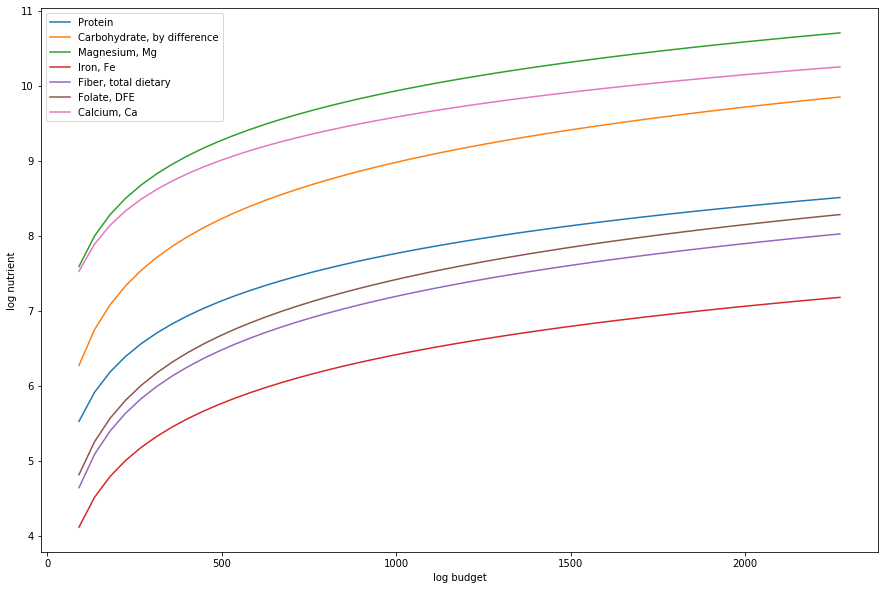

In [56]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(medianx/5,medianx*5,50).tolist()

UseNutrients = ['Protein','Carbohydrate, by difference', 'Magnesium, Mg', 'Iron, Fe', 'Fiber, total dietary', 'Folate, DFE', 'Calcium, Ca']

# Use reference prices
logN={}
for myx in X:
    logN[myx] = np.log(nutrient_demand(myx)[UseNutrients])
    
logN = pd.concat(logN,axis=1).T

plt.figure(figsize=(15,10));
plt.plot(X,logN);
plt.legend(UseNutrients);
plt.xlabel('log budget');
plt.ylabel('log nutrient');

Now how does nutrition vary with prices at median income?



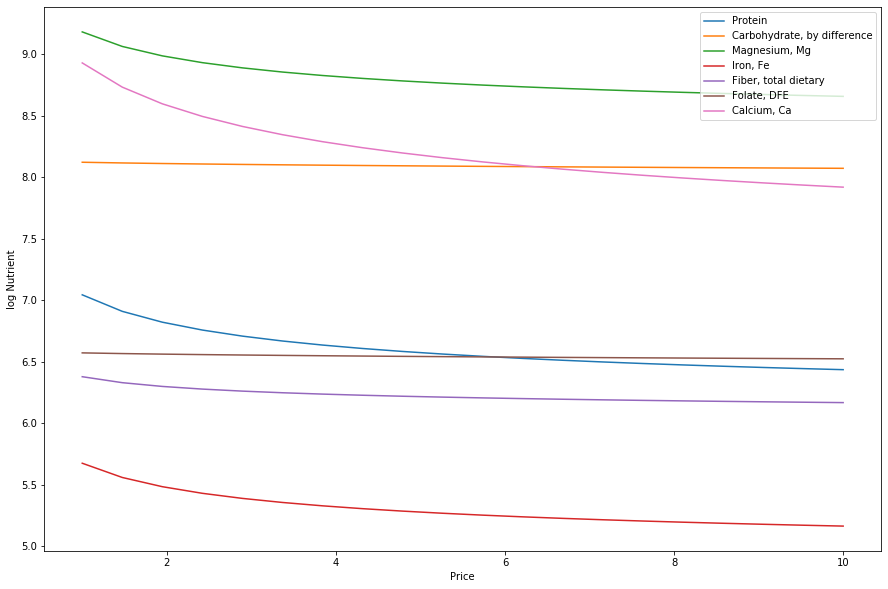

In [63]:
# Choosing specific good to analyze
USE_GOOD = 'Haricot Beans'

P = np.linspace(1,10,20).tolist()

plt.figure(figsize=(15,10));
plt.plot(P,pd.concat({p0:np.log(nutrient_demand(medianx,pscale={USE_GOOD:p0})[UseNutrients]) for p0 in P},axis=1).T);
plt.legend(UseNutrients, loc=1);
plt.xlabel('Price');
plt.ylabel('log Nutrient');